In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
# sys.path.append('/Users/Runze/Documents/dl/fastai/fastai/courses/dl1')
sys.path.append('/home/nbuser/courses/fastai2/courses/dl1')

In [3]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from sklearn import model_selection

In [4]:
PATH = 'data'
!ls {PATH}

labels.csv  models  test  tmp  train  valid


In [8]:
!ls {PATH}/train | wc -l
!ls {PATH}/test | wc -l
!wc -l {PATH}/labels.csv

120
10357
10223 data/labels.csv


## Preprocess data

In [6]:
# Load labels
labels = pd.read_csv(f'{PATH}/labels.csv')
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [7]:
len(labels['breed'].unique())

120

In [8]:
# Split training data into training and validation sets
SEED = 123456

In [9]:
id_trn, id_val, breed_trn, breed_val = model_selection.train_test_split(
    labels['id'],
    labels['breed'],
    test_size=0.25,
    stratify=labels['breed'],
    random_state=SEED)

In [10]:
len(id_trn), len(id_val), len(breed_trn), len(breed_val)

(7666, 2556, 7666, 2556)

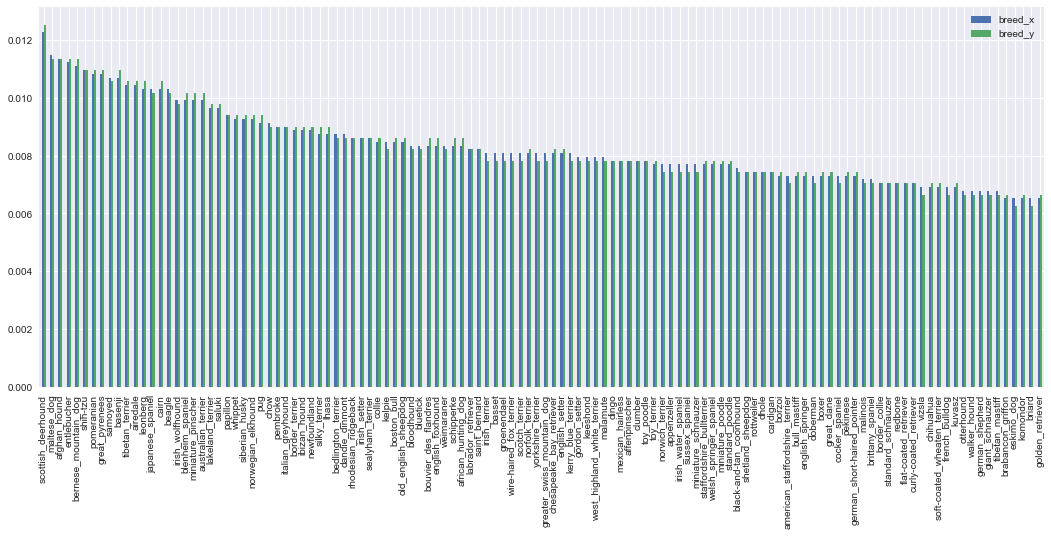

In [11]:
pd.merge(
    pd.DataFrame(breed_trn.value_counts(normalize=True)),
    pd.DataFrame(breed_val.value_counts(normalize=True)),
    left_index=True,
    right_index=True
).plot.bar(figsize=(18, 7))

In [12]:
# Move files into the respective label folders
os.makedirs(f'{PATH}/valid', exist_ok=True)

In [13]:
for breed in labels['breed'].unique():
    os.makedirs(f'{PATH}/train/{breed}', exist_ok=True)
    os.makedirs(f'{PATH}/valid/{breed}', exist_ok=True)

In [14]:
# Check file extensions
files = !ls {PATH}/train
files = [fn.split('.') for fn in files]
pd.Series([fn[1] for fn in files if len(fn) == 2]).value_counts()

jpg    10222
dtype: int64

In [15]:
for i in id_trn.index:
    !mv {PATH}/train/{id_trn[i]}.jpg {PATH}/train/{breed_trn[i]}/{id_trn[i]}.jpg

In [16]:
for i in id_val.index:
    !mv {PATH}/train/{id_val[i]}.jpg {PATH}/valid/{breed_val[i]}/{id_val[i]}.jpg

## Check out pictures

In [20]:
files_sample = !ls {PATH}/train/samoyed | head
files_sample

['041b3b8a40b587a486276ac15edd9eaf.jpg',
 '093a146e173a3fd9ea650b87f08d6222.jpg',
 '0a6706f7864eb8871913f0e4ba07a61e.jpg',
 '0a77d498ff491945347bb895d8ae4008.jpg',
 '0cbca2fcad7910a3c98d734e17cfde65.jpg',
 '0ddbc4702eff570783cd03645571e7f7.jpg',
 '0fc6556b7504fc473d8bdaa0a555a4de.jpg',
 '18b631157527e14b007e570175c921a3.jpg',
 '1929eb9a7cf1fe75c0731a27545d8893.jpg',
 '1ac99811729824259ded81d3bbed7762.jpg']

In [21]:
img = plt.imread(f'{PATH}/train/samoyed/{files_sample[0]}')
img.shape

(389, 500, 3)

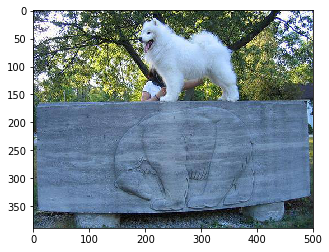

In [22]:
plt.imshow(img)

## A model using resnet34

In [5]:
arch = resnet34
sz = 224

### Data augmentation

In [6]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

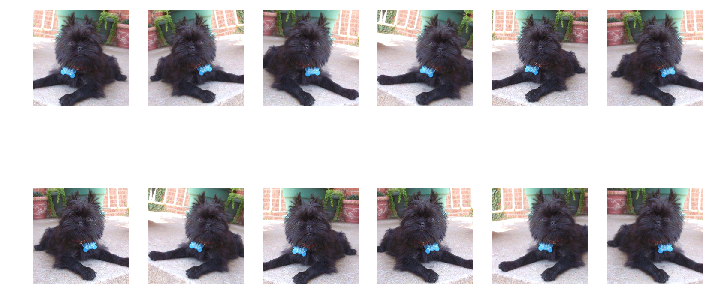

In [7]:
# Check out data augmentation
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

ims = np.stack([get_augs() for i in range(12)])
plots(ims, rows=2)

In [8]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms, trn_name='train', val_name='valid', test_name='test')

In [30]:
data.trn_ds.n, data.val_ds.n, len(data.classes)

(7666, 2556, 120)

### Load pre-trained model

In [10]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 162/162 [03:37<00:00,  1.35s/it]


### Choose an initial learning rate

In [11]:
lrf = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 94%|█████████▍| 113/120 [00:06<00:00, 17.09it/s, loss=18.4]


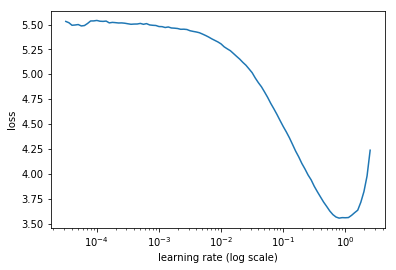

In [12]:
learn.sched.plot()

### Train model

In [13]:
learn.fit(lrs=0.01, n_cycle=10, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

[ 0.       2.62251  2.04198  0.6313 ]                       
[ 1.       1.62156  1.10925  0.76648]                       
[ 2.       1.14878  0.83591  0.79784]                       
[ 3.       0.92048  0.72328  0.81148]                        
[ 4.       0.78736  0.65994  0.81349]                        
[ 5.       0.71611  0.61735  0.823  ]                        
[ 6.       0.65741  0.58859  0.82958]                        
[ 7.       0.60674  0.57731  0.82919]                        
[ 8.       0.5534   0.56084  0.83151]                        
[ 9.       0.51456  0.55208  0.83117]                        



In [16]:
# Learn another 10 epochs because the validation loss is still decreasing
learn.fit(lrs=0.01, n_cycle=10, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

[ 0.       0.45539  0.54319  0.83081]                        
[ 1.       0.46251  0.5369   0.83005]                        
[ 2.       0.43734  0.53407  0.83354]                        
[ 3.       0.42474  0.53104  0.83667]                        
[ 4.       0.40672  0.52549  0.83865]                        
[ 5.       0.37811  0.52191  0.83711]                        
[ 6.       0.3815   0.52428  0.83789]                        
[ 7.       0.37933  0.52499  0.83279]                        
[ 8.       0.34918  0.52367  0.83432]                        
[ 9.       0.33296  0.52167  0.83781]                        



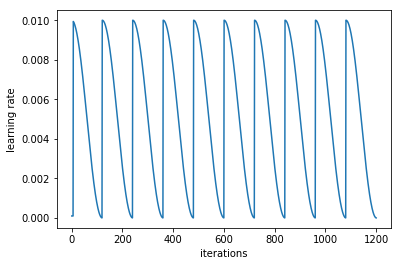

In [17]:
learn.sched.plot_lr()

In [47]:
learn.save('dog_breed_resnet34')

### Predict on test set

In [19]:
log_preds, _ = learn.TTA(is_test=True)

In [38]:
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds)

In [42]:
len(np.unique(preds))

120

In [46]:
probs.sum(axis=1).mean()

1.0

In [79]:
class_id_samoyed = np.where(np.array(data.classes) == 'samoyed')[0][0]
file_id_samoyed = np.where(preds == class_id_samoyed)[0][0]

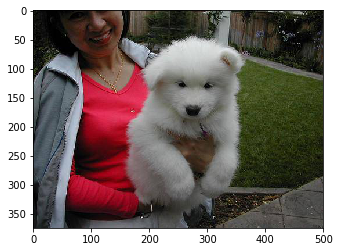

In [84]:
test_fns = data.test_dl.dataset.fnames
img = plt.imread(f'{PATH}/{test_fns[file_id_samoyed]}')
plt.imshow(img)

In [52]:
probs = pd.DataFrame(probs)

In [54]:
probs.columns = data.classes

In [85]:
probs['id'] = 

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,1.141368e-06,3.847774e-06,1.016564e-06,9.877287e-01,4.602392e-07,6.924306e-07,3.625379e-06,4.452748e-06,1.193624e-06,3.805809e-06,...,0.000004,2.087509e-06,7.309826e-06,5.009746e-06,0.000004,1.573279e-06,1.654151e-06,0.000001,0.000903,3.122634e-05
1,8.581216e-01,4.020727e-05,2.683944e-04,1.676976e-05,1.543249e-05,2.682174e-04,2.573188e-04,5.280437e-06,2.796435e-05,4.466492e-05,...,0.000029,6.272487e-06,6.584257e-06,3.441744e-05,0.000012,6.912345e-05,2.566868e-03,0.000006,0.001340,1.539106e-03
2,9.867837e-06,3.532693e-03,3.413896e-05,2.379424e-04,5.077583e-07,1.164306e-06,6.701844e-06,2.861660e-06,7.484576e-05,5.787939e-06,...,0.000121,3.680738e-05,3.217232e-05,2.547370e-04,0.000037,7.691862e-04,4.844446e-06,0.000014,0.000369,5.062724e-05
3,7.896624e-03,1.345372e-05,3.307377e-04,1.233791e-05,4.510210e-06,9.568081e-05,1.960616e-04,9.883514e-05,2.446428e-05,4.273552e-04,...,0.007624,3.357169e-04,4.541143e-04,9.959735e-06,0.000028,1.721342e-05,4.936865e-05,0.000006,0.000001,6.405513e-05
4,3.458148e-09,1.184267e-07,5.234218e-07,8.290559e-07,1.197179e-07,4.265630e-08,5.095346e-09,2.632057e-08,2.089452e-08,8.528184e-09,...,0.000002,8.680620e-07,8.026232e-09,1.739820e-07,0.000002,1.980877e-09,1.313340e-07,0.000002,0.000024,1.057287e-08


In [103]:
test_fns = [re.split('/|\.', fn) for fn in test_fns]
test_ids = [fn[1] for fn in test_fns]

probs['id'] = test_ids

In [110]:
columns = list(probs)
columns.insert(0, columns.pop(columns.index('id')))

probs = probs[columns]
probs.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,9d591f86fdd00f9731dc51d68c7b6323,1.141368e-06,3.847774e-06,1.016564e-06,9.877287e-01,4.602392e-07,6.924306e-07,3.625379e-06,4.452748e-06,1.193624e-06,...,0.000004,2.087509e-06,7.309826e-06,5.009746e-06,0.000004,1.573279e-06,1.654151e-06,0.000001,0.000903,3.122634e-05
1,6893b5ed882c7ae791e4a440f613a3f8,8.581216e-01,4.020727e-05,2.683944e-04,1.676976e-05,1.543249e-05,2.682174e-04,2.573188e-04,5.280437e-06,2.796435e-05,...,0.000029,6.272487e-06,6.584257e-06,3.441744e-05,0.000012,6.912345e-05,2.566868e-03,0.000006,0.001340,1.539106e-03
2,2a1c95b9f131236b715df75ff815fd0b,9.867837e-06,3.532693e-03,3.413896e-05,2.379424e-04,5.077583e-07,1.164306e-06,6.701844e-06,2.861660e-06,7.484576e-05,...,0.000121,3.680738e-05,3.217232e-05,2.547370e-04,0.000037,7.691862e-04,4.844446e-06,0.000014,0.000369,5.062724e-05
3,87e96ca57ae92a499e057debb62fc232,7.896624e-03,1.345372e-05,3.307377e-04,1.233791e-05,4.510210e-06,9.568081e-05,1.960616e-04,9.883514e-05,2.446428e-05,...,0.007624,3.357169e-04,4.541143e-04,9.959735e-06,0.000028,1.721342e-05,4.936865e-05,0.000006,0.000001,6.405513e-05
4,d2da98041804728e98d85b9ee42571a3,3.458148e-09,1.184267e-07,5.234218e-07,8.290559e-07,1.197179e-07,4.265630e-08,5.095346e-09,2.632057e-08,2.089452e-08,...,0.000002,8.680620e-07,8.026232e-09,1.739820e-07,0.000002,1.980877e-09,1.313340e-07,0.000002,0.000024,1.057287e-08


In [111]:
probs.to_csv(f'{PATH}/pred_probs.csv', index=False)